In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof
import earthplot as eplt
import sys
sys.path.append("..")
import array_func as af
# from .. import array_func as af


In [2]:
from scipy import stats

def regress_xr(x, y, leastpercent=1.0):
    """x is a multi-dimensional array, y is a one-dimension series"""

    def regrerssion(a, b):
        if not np.any(np.isnan(a)):
            z1 = stats.linregress(b, a)
            return z1[0], z1[3]
        elif (not np.all(np.isnan(a))) and ((~np.isnan(a)).sum()>=(a.shape[0]*leastpercent)):
            z1 = stats.linregress(b[~np.isnan(a)], a[~np.isnan(a)])
            return z1[0], z1[3]
        else:
            return np.nan, np.nan

    # input_core_dims: dimensions that should not be broadcast
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(
        regrerssion,  # first the function
        # x.chunk({x.dims[-2]: 5, x.dims[-1]: 5}), # 若用chunk，如果不需要compute()或load()还挺快(未必比不用chunk快)，如果需要反而变慢了
        x,
        y,
        input_core_dims=[[x.dims[0]], [x.dims[0]]],  # list with one entry per arg
        output_core_dims=[[], []], #[z.dims[1:], z.dims[1:]],
        vectorize=True,  # not needed since numba takes care of vectorizing
        # dask="parallelized",  # 若x使用了chunk，则需要这个参数
        # output_dtypes=[x.dtype],  # one per output
        keep_attrs=True,
    )

In [3]:
pcs = xr.open_dataarray('data/Pre_PCs.nc')
eofs = xr.open_dataarray('data/Pre_EOFs.nc')

years_train = list(range(2000, 2018))
pre_month = xr.open_dataarray('data/pre.yunnan.2000-2023.month.roll.nc')
pre_month_train = pre_month[pre_month.time.dt.year.isin(years_train)]
n_train = len(pre_month_train)

pre_reshape = af.reshape_year_day(pre_month_train)  # arr_reshape and arr1 share memory
pre_clim =  pre_reshape.mean('year')

pre_month_ano = af.calc_ano_daily(pre_month, clim_window=None, clim=pre_clim).drop_vars(['lon', 'lat', 'station_name']) # drop for SVD
lon_stn = pre_month.lon
lat_stn = pre_month.lat

initial_calendar_days = ['05-01', '05-11', '05-21', 
                         '06-01', '06-11', '06-21',
                         '07-01', '07-11', '07-21',
                         '08-01', '08-11', '08-21',
                         '09-01']

In [4]:
import cartopy.io.shapereader as shpreader
shp_path = r'D:\research\data\china-shapefiles\aliyun\shp\china\china'
province_names = ['云南省']
china_shp = shpreader.Reader(shp_path+'.shp')
yunnan = [prov.geometry for prov in china_shp.records() if prov.attributes["name"] in province_names]

Text(0.46, 1.05, 'Yunnan Precipitation')

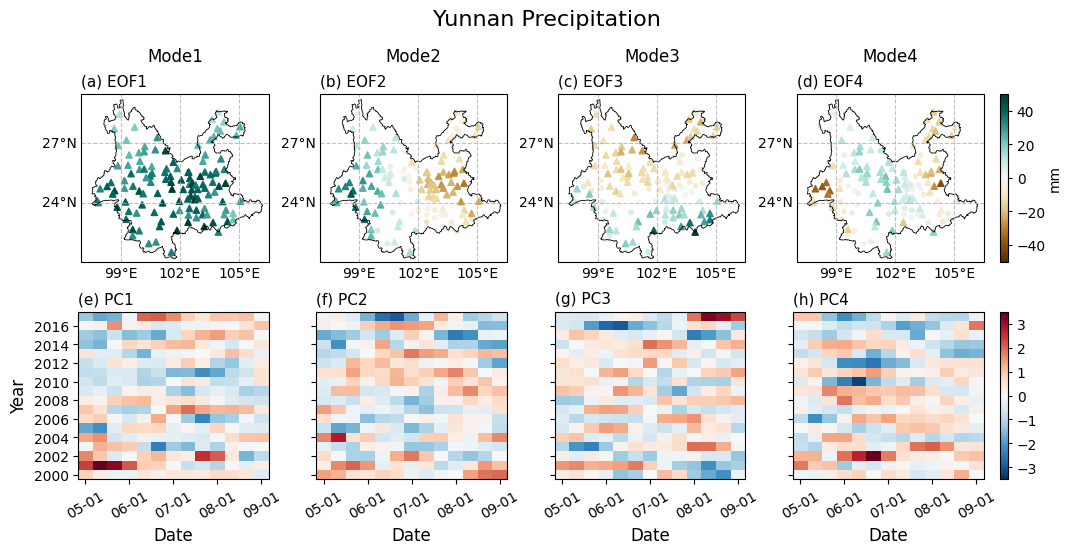

In [5]:
n_retain = 4
pvalue = 0.05

fig, axs = eplt.subplots(nrows=2, ncols=n_retain, figsize=[14, 5], hratios=(1, 1),
                         wspace=0.25, hspace=0.3, # hspace=0.7, 
                         proj=('cyl',)*n_retain+(None,)*n_retain)
eplt.formats(axs, abc='(a)', toplabels=[f'Mode{i+1}' for i in range(n_retain)])
eplt.formats(axs[0, :], geo=True, latlim=(21, 29.5), lonlim=(97., 106.5),
             # latlim=(0, 60), lonlim=(40, 150),
             latloc=3, lonloc=3, reso='med')
eplt.formats(axs[1, :], xlabel='Date', ylabel='Year', sharey=True,
             xticks=np.arange(len(initial_calendar_days))[::3], 
             xticklabels=initial_calendar_days[0::3], )

pcs_norm = pcs.copy()[pre_month_ano.time.dt.year.isin(years_train)]

vmax = 50
# for i in range(n_retain):
for i, imode in enumerate(range(0, n_retain)):
    pcs_norm[:, imode] = stats.zscore(pcs_norm[:, imode].values, ddof=1)
    eof_reg, p_eof = regress_xr(pre_month_ano[pre_month_ano.time.dt.year.isin(years_train)], 
                                pcs_norm[:, imode])

    ax1 = axs[0, i]
    title1 = f'EOF{imode+1}'
    eplt.formats(ax1, ltitle=title1, titlesize=11) #list(range(-60,80,20))
    
    if (p_eof>pvalue).sum() > 0:
        ax1.scatter(lon_stn[p_eof>pvalue], lat_stn[p_eof>pvalue],
                    c=eof_reg[p_eof>pvalue], vmin=-vmax, vmax=vmax,
                    marker='o', s=10, cmap='BrBG')
    if (p_eof<=pvalue).sum() > 0:
        pic1 = ax1.scatter(lon_stn[p_eof<=pvalue], lat_stn[p_eof<=pvalue],
                    c=eof_reg[p_eof<=pvalue], vmin=-vmax, vmax=vmax,
                    marker='^', s=20, cmap='BrBG')
    ax1.add_geometries(yunnan, crs=ax1.projection, fc='none', ec='k', lw=0.6)

    ax2 = axs[1, i]
    pic2 = ax2.pcolormesh(np.arange(len(initial_calendar_days)), years_train, 
                          pcs_norm[:, imode].values.reshape(-1, 13), 
                          vmax=3.5, vmin=-3.5, cmap='RdBu_r')
    eplt.formats(ax2, ltitle='PC'+str(imode+1), titlesize=11, yticks=2, 
                 xtick_params={'rotation':30})
    # aa = {'rotation':30}
    # ax2.tick_params(axis='x', **aa)

eplt.addcolorbar(axs[0, :], pic1, loc='r', label='mm', pad=0.015)
eplt.addcolorbar(axs[1, :], pic2, loc='r', label='', pad=0.015, ticks=1)

fig.suptitle('Yunnan Precipitation', fontsize=16, y=1.05, x=0.46)


In [6]:
axs[0,:].shape[-1]

4

Text(0.5, 1.2, 'Top Label')

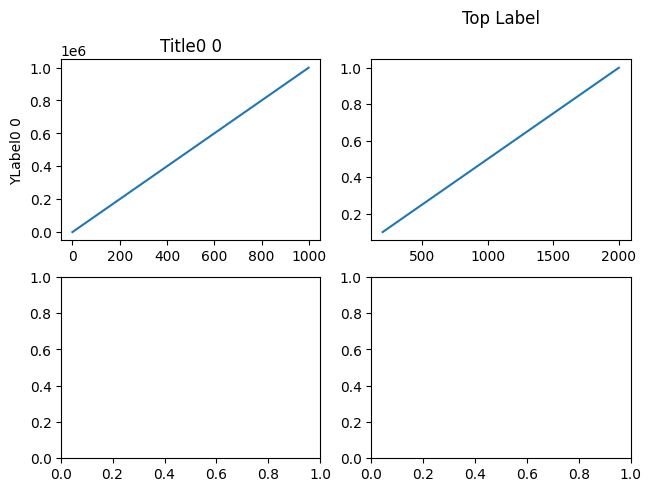

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, layout='constrained')

ax = axs[0][0]
ax.plot(np.arange(0, 1e6, 1000))
ax.set_title('Title0 0')
ax.set_ylabel('YLabel0 0')

ax = axs[0][1]
ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
# ax.set_title('Title0 1')

# ax.xaxis.tick_top()
# ax.tick_params(axis='x', rotation=55)


# for i in range(2):
#     ax = axs[1][i]
#     ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
#     ax.set_ylabel('YLabel1 %d' % i)
#     ax.set_xlabel('XLabel1 %d' % i)
#     if i == 0:
#         ax.tick_params(axis='x', rotation=55)

# fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
# fig.align_titles()

ax.text(0.5, 1.2, 'Top Label', transform=ax.transAxes, ha='center', fontsize='large')
